## plot the mcmc sampling result

In [1]:

import os, sys
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap
from getdist import plots
from desilike.samples import plotting, Chain, Profiles
from desilike.parameter import ParameterCollection

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

ERROR:2025-12-05 11:53:10,398:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda13.initialize()
Traceback (most recent call last):
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/jax_plugins/xla_cuda13/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/jax_plugins/xla_cuda13/__init__.py", line 150, in _check_cuda_versions
    assert cuda_versions is not None
           ^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
/global/homes/s/shengyu/.conda/envs/fit_env/lib/python3.11/site-packages/desilike/jax.py:29: UserWarning: Could *not* import jax and dependencies, got error:
Traceback (most recent call last):
  File "/global/hom

In [29]:
sys.path.append('../')
from helper import PLANCK_COSMOLOGY, REDSHIFT_BIN_LSS
from plotting_tools import get_mcmc_plot_args, COLOR_TRACERS, get_namespace, plot_observable
from fitting_tools import load_blinded_data_pip, load_bins, get_template, get_theory, get_measurement_fn, get_observable_likelihood
%load_ext autoreload
%autoreload 2

# RESULT_DIR = '/pscratch/sd/s/shengyu/Y3/results/test/full-shape'
RESULT_DIR = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results'
SAVE_DIR = '/global/homes/s/shengyu/Y3/blinded_data_splits/main/results'
save_fig = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# fit settings
fit       = 'FM'
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'

# load all the chains
(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])

tracers = ['BGS','LRG','ELG','QSO'] # 'BGS','LRG', 'ELG', 'QSO' 
weight_type = 'default_fkp'
regions = ["GCcomb", "NGC", "SGC"]
TRACER_BINS = [(tracer, zrange) for tracer, zranges in REDSHIFT_BIN_LSS.items()
               if tracer in tracers for zrange in zranges]

all_chains = {}
for tracer, zrange in TRACER_BINS:
    for region in regions:
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        chain_fn = (RESULT_DIR + f'/full-shape/mcmc/chain_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}.npy')
        chain = Chain.load(chain_fn)
        all_chains[f'{tracer}_{zrange}_{region}'] = chain

## Plot the 1d constraints

/tmp/ipykernel_2257901/613142196.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


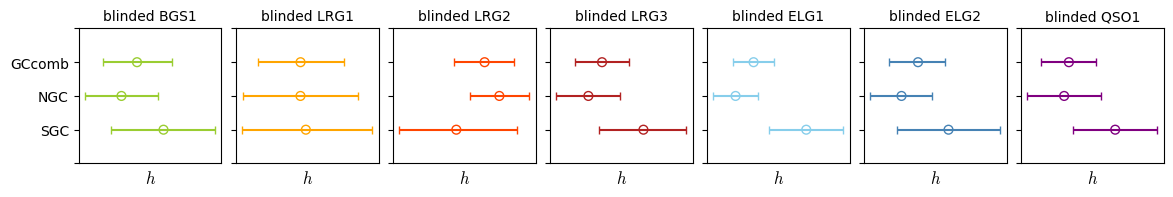

/tmp/ipykernel_2257901/613142196.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


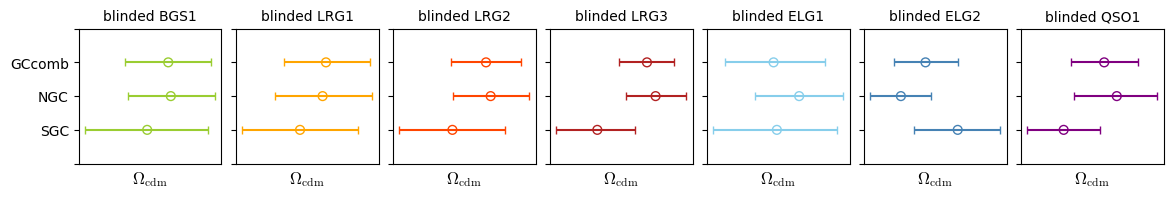

/tmp/ipykernel_2257901/613142196.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


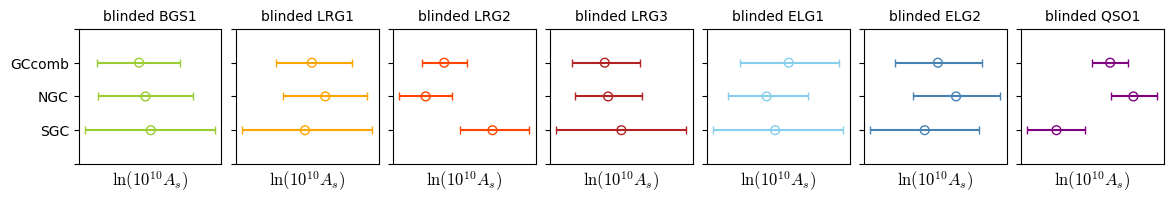

In [38]:
regions = ["GCcomb", "NGC", "SGC"]
for param, param_label in zip(mcmc_args['params'], mcmc_args['params_label']):
    fig = plt.figure(figsize=(2*len(TRACER_BINS), 0.5*len(regions)))
    gs = gridspec.GridSpec(1, len(TRACER_BINS),  wspace=0.1, hspace=0.0, top=0.95, bottom=0.05)
    n_bins = len(TRACER_BINS)
    yticks = np.arange(len(regions)+2)
    for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        plt.rcParams['mathtext.fontset'] = 'cm' 
        ax = fig.add_subplot(gs[0, ind_col])
        tracer_label = get_namespace(tracer, zrange)
        ax.set_title(f"blinded {tracer_label}", fontsize=10)
        ax.set_yticks(yticks)
        if ind_col == 0:
            ax.set_yticklabels(['']+regions+[''], fontsize=10)
        else:
            ax.set_yticklabels([])
        ax.set_xlabel(param_label, fontsize =12)
        color = COLOR_TRACERS[tracer_label]
        # plot the truth values
        # ax.axvline(mcmc_args['true_values'][param], color='k', linestyle='--', linewidth=1, alpha=0.8,)
        # plot the 1d constraint
        for y, region in enumerate(regions):
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            mean = chain.mean(params=param)
            q05, q95 = chain.quantile(params=param)  # 5% and 95%
            # horizontal guide line for the region
            ax.scatter(mean, y+1,  edgecolors=color, facecolors='none', s=40)
            ax.errorbar(mean, y+1, xerr=[[mean - q05], [q95 - mean]], color=color, capsize=3)
            ax.set_ylim([0,len(regions)+1])
        ax.invert_yaxis()
        ax.set_yticks(ax.get_yticks()[::-1])
        ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    plt.tight_layout()
    plt.show()
    if save_fig == True:
        fig.savefig(SAVE_DIR+f'/plots/1d_constraint_{fit}_{param}_GCcompare.png', dpi=300, bbox_inches='tight')

## Summary Table (the difference)

In [39]:
df = pd.read_csv(SAVE_DIR+f"/tables/table_{fit}fit_values.csv")

# Compute std
df["std"] = 0.5 * (df["q95"] - df["q05"])

tracer_labels = get_namespace(tracer, zrange)

df["value"] = df.apply(lambda r: f"{r['mean']:.3f} ± {r['std']:.3f}", axis=1)
# ---- Build pivot table ----
table = df.pivot_table(index=["param", "region"],   # Multi-index rows
                       columns="name",              # each tracer_bin becomes a column
                       values="value",
                       aggfunc="first")

# Sort rows by param order and region order
region_order = ["GCcomb", "NGC", "SGC"]
table = table.reindex(regions, level="region")
table = table.reindex(mcmc_args['params'], level="param")
table = table[['BGS1', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO1']]

chi2_rows = (df.groupby(["region", "name"])["chi2"].first().unstack("name"))
chi2_rows = chi2_rows.applymap(lambda x: f"{x:.2f}")
chi2_rows.index = pd.MultiIndex.from_product([["chi2"], chi2_rows.index], names=["param", "region"],)

table = pd.concat([table, chi2_rows])

pd.set_option("display.width", 1000)      # very wide output
print(table)

name                       BGS1           LRG1           LRG2           LRG3           ELG1           ELG2           QSO1
param     region                                                                                                         
h         GCcomb  0.699 ± 0.020  0.679 ± 0.015  0.714 ± 0.016  0.674 ± 0.011  0.684 ± 0.018  0.712 ± 0.014  0.669 ± 0.021
          NGC     0.691 ± 0.021  0.679 ± 0.020  0.722 ± 0.016  0.668 ± 0.013  0.668 ± 0.020  0.704 ± 0.016  0.666 ± 0.027
          SGC     0.714 ± 0.030  0.681 ± 0.023  0.699 ± 0.032  0.691 ± 0.018  0.732 ± 0.034  0.728 ± 0.026  0.704 ± 0.031
omega_cdm GCcomb  0.122 ± 0.011  0.122 ± 0.009  0.124 ± 0.010  0.116 ± 0.008  0.105 ± 0.011  0.127 ± 0.009  0.128 ± 0.008
          NGC     0.122 ± 0.011  0.121 ± 0.010  0.126 ± 0.011  0.119 ± 0.009  0.111 ± 0.010  0.120 ± 0.008  0.131 ± 0.010
          SGC     0.116 ± 0.016  0.116 ± 0.012  0.114 ± 0.016  0.101 ± 0.012  0.106 ± 0.014  0.136 ± 0.012  0.118 ± 0.008
logA      GCcomb  2.851 

/tmp/ipykernel_2257901/2970669405.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chi2_rows = chi2_rows.applymap(lambda x: f"{x:.2f}")


In [36]:
import pandas as pd
df = pd.read_csv(SAVE_DIR + f"/tables/table_{fit}fit_values.csv")

# Clean region labels just in case: strip spaces, newlines, etc.
df["region"] = df["region"].astype(str).str.strip()
df["std"] = 0.5 * (df["q95"] - df["q05"])

# ----- build baseline (GCcomb) -----
base = (
    df[df["region"] == "GCcomb"]
    [["param", "name", "mean", "std"]]
    .rename(columns={"mean": "mean_base", "std": "std_base"})
)

# ----- NGC and SGC only -----
others = df[df["region"].isin(["NGC", "SGC"])] \
    [["param", "region", "name", "mean"]]

# ----- merge to attach baseline -----
merged = others.merge(base, on=["param", "name"], how="left")
merged["diff"] = merged["mean"] - merged["mean_base"]
merged["abs_norm"] = (merged["mean"] - merged["mean_base"]).abs() / merged["std_base"]
merged["val_str"] = merged["abs_norm"].apply(lambda x: f"{x:.2f}")
# merged["val_str"] = merged.apply(
#     lambda r: f"{r['diff']:.3f} ± {r['std_base']:.3f}",
#     axis=1,
# )

# ----- pivot to table -----
table_diff = merged.pivot_table(
    index=["param", "region"],
    columns="name",
    values="val_str",
    aggfunc="first"
)

if fit == 'FM': 
    param_order = ["h", "omega_cdm", "logA"] 
    label_map = {
        "h":         r"$\Delta h $",
        "omega_cdm": r"$\Delta\Omega_{\mathrm{cdm}} $",
        "logA":      r"$\Delta \ln(10^{10}A_s) $",
    }
elif fit == 'SF':
    param_order = ["qiso", "qap", "dm", "df"] 
    label_map = {
        "qiso": r"$\Delta \alpha_{\mathrm{iso}} $",
        "qap":  r"$\Delta \alpha_{\mathrm{ap}} $",
        "dm":   r"$\Delta d_m  $",
        "df":   r"$\Delta d_f  a$",}


# order
chi2 = df.pivot_table(
    index="region",
    columns="name",
    values="chi2",
    aggfunc="first",
)
region_order = ["NGC", "SGC"]
col_order    = ['BGS1', 'LRG1', 'LRG2', 'LRG3', 'ELG1', 'ELG2', 'QSO1']

table_diff = table_diff.reindex(param_order, level="param")
table_diff = table_diff.reindex(region_order, level="region")
table_diff = table_diff.reindex(columns=col_order)

table_diff.index = table_diff.index.set_levels(
    [label_map.get(p, p) for p in table_diff.index.levels[0]],
    level="param"
)

# order regions + tracers
chi2_region_order = ["GCcomb", "NGC", "SGC"]
chi2 = chi2.reindex(chi2_region_order)
chi2 = chi2.reindex(columns=col_order)

# format χ² (e.g. 1 decimal place)
chi2_str = chi2.applymap(lambda x: f"{x:.1f}")

# give χ² a MultiIndex to match (param, region)
chi2_str.index = pd.MultiIndex.from_product(
    [[r"$\chi^2$ \n dof = (72-13)"], chi2_str.index],
    names=["param", "region"],
)

# concat value table + chi2 block
table_full = pd.concat([table_diff, chi2_str])

print(table_full)

name                                    BGS1  LRG1  LRG2  LRG3  ELG1  ELG2   QSO1
param                           region                                           
$\Delta \alpha_{\mathrm{iso}} $ NGC     0.80  0.30  0.23  0.84  0.70  0.36   0.66
                                SGC     3.07  0.91  2.70  1.13  1.13  0.07   0.59
$\Delta \alpha_{\mathrm{ap}} $  NGC     0.11  0.04  0.34  0.27  0.28  0.44   0.45
                                SGC     0.97  1.86  0.84  0.53  0.04  0.09   0.60
$\Delta d_m  $                  NGC     0.19  0.08  0.26  0.43  0.00  0.07   0.56
                                SGC     3.57  1.76  2.82  0.94  1.26  1.47   2.32
$\Delta d_f  a$                 NGC     0.25  0.42  0.89  0.18  0.06  0.32   1.55
                                SGC     0.01  1.36  1.94  0.65  0.20  1.28   2.67
$\chi^2$ \n dof = (72-13)       GCcomb  58.0  55.6  59.8  70.1  70.1  53.1  118.7
                                NGC     50.3  68.1  54.3  64.1  66.9  58.1  116.3
                

/tmp/ipykernel_2257901/824256819.py:78: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  chi2_str = chi2.applymap(lambda x: f"{x:.1f}")


## plot the best fit and clustering

36
36
36
36
36
36


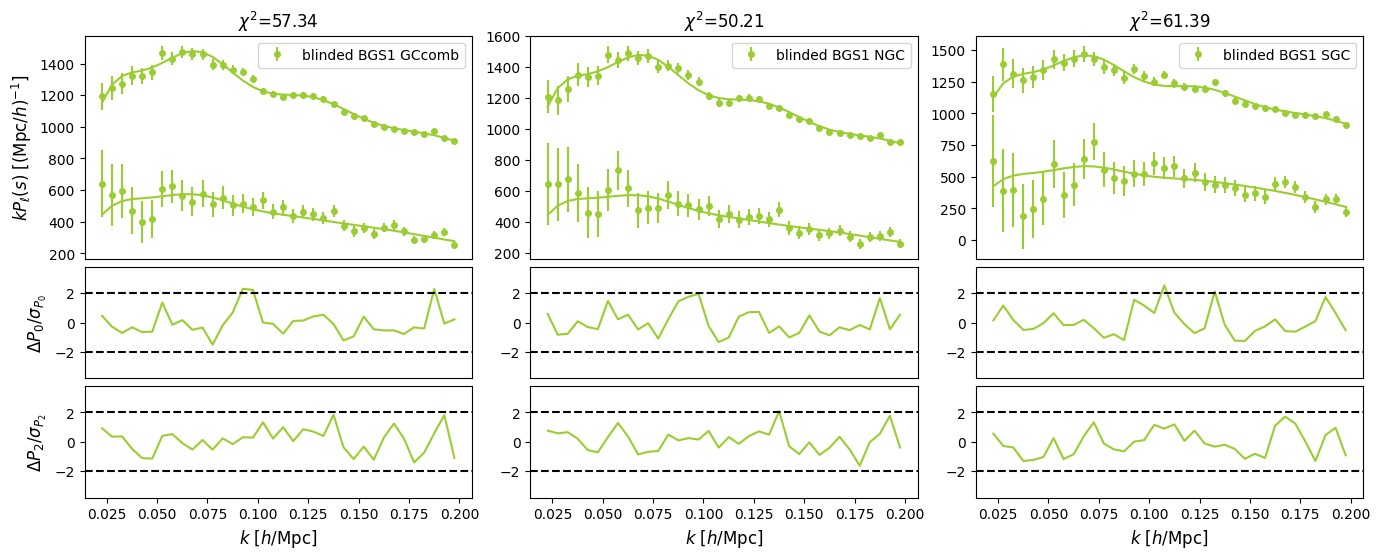

36
36
36
36
36
36


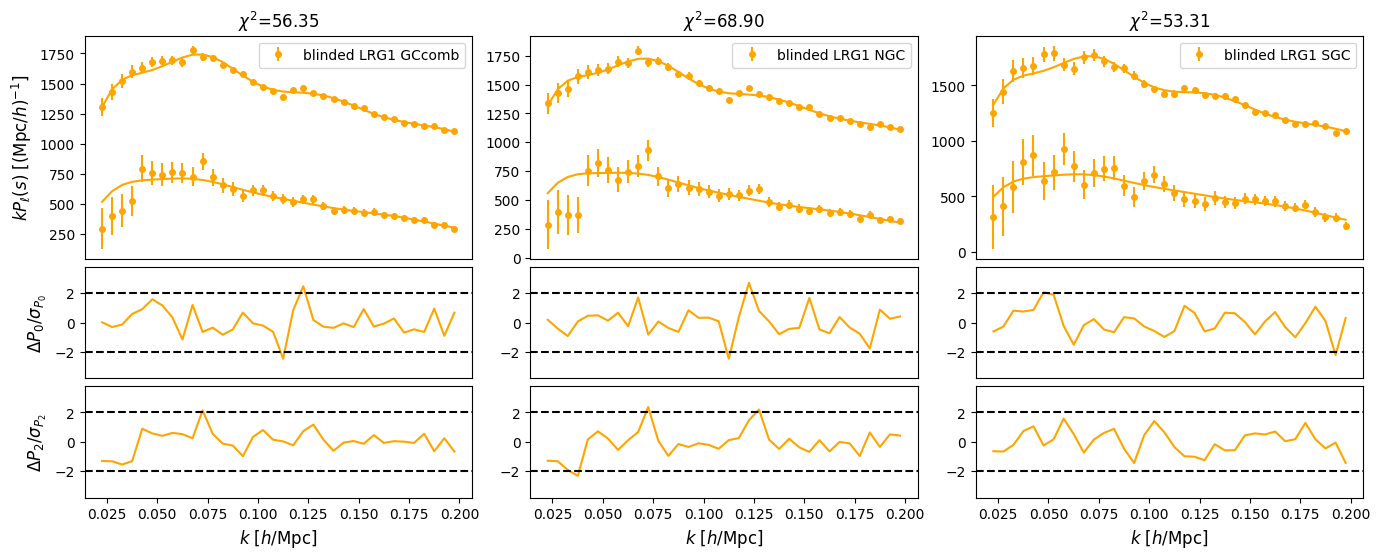

36
36
36
36
36
36


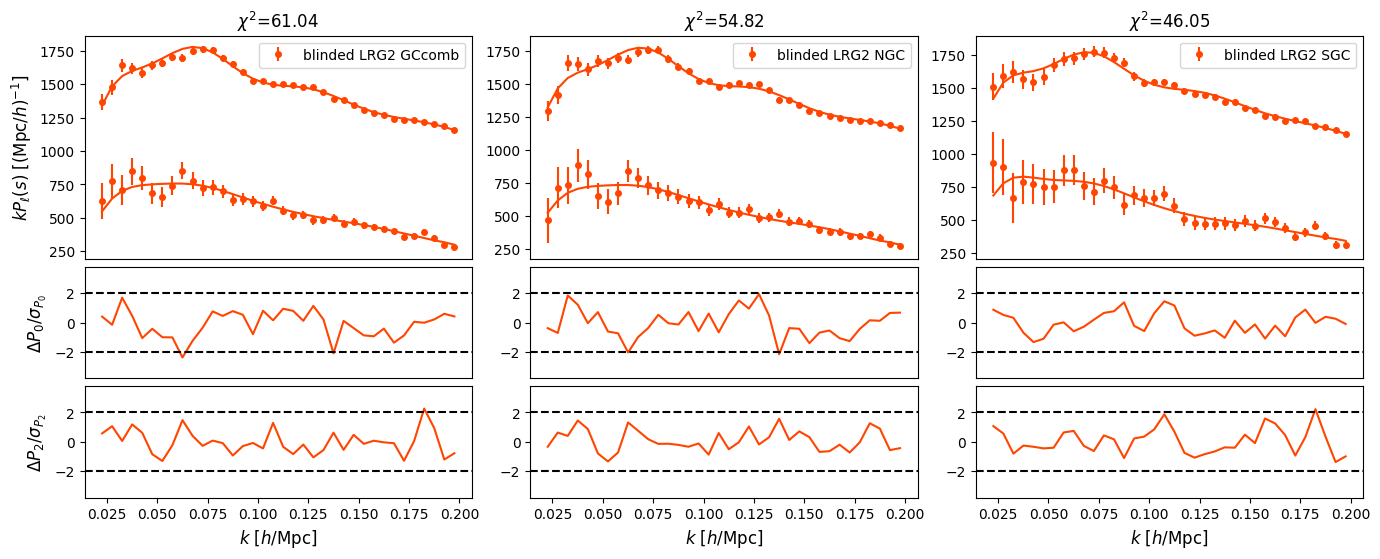

36
36
36
36
36
36


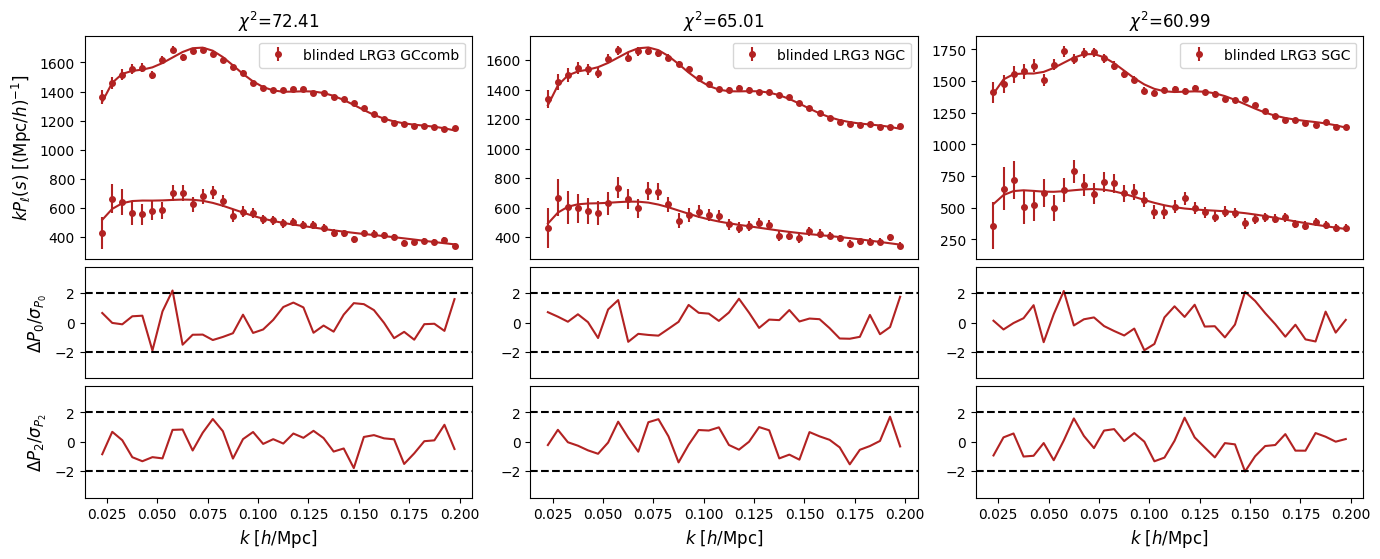

36
36
36
36
36
36


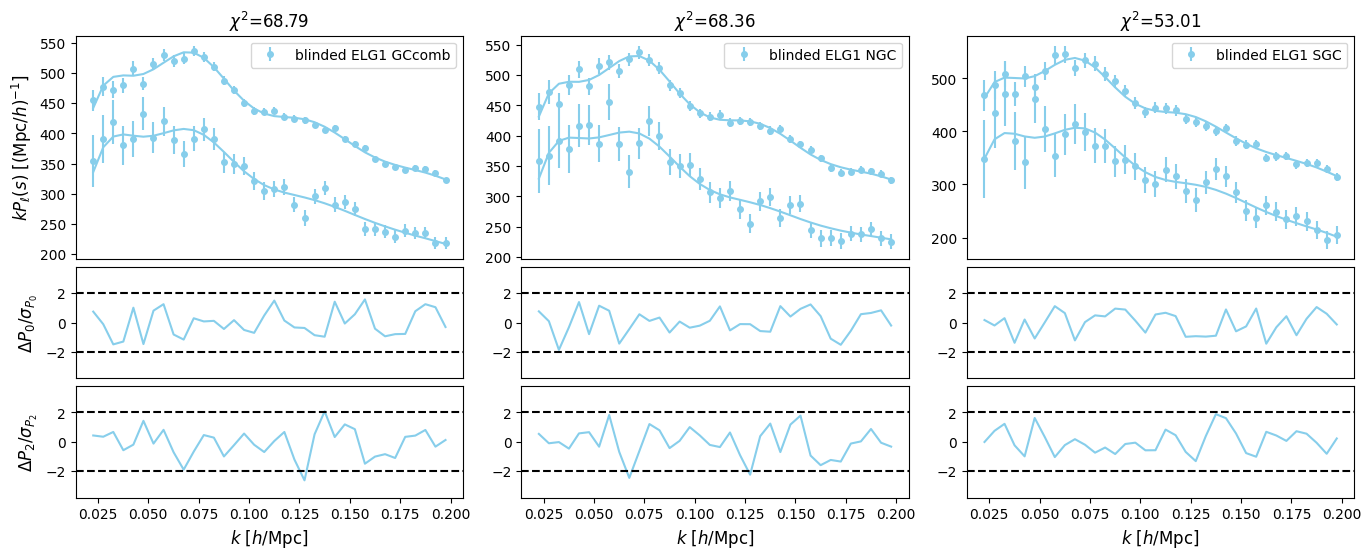

36
36
36
36
36
36


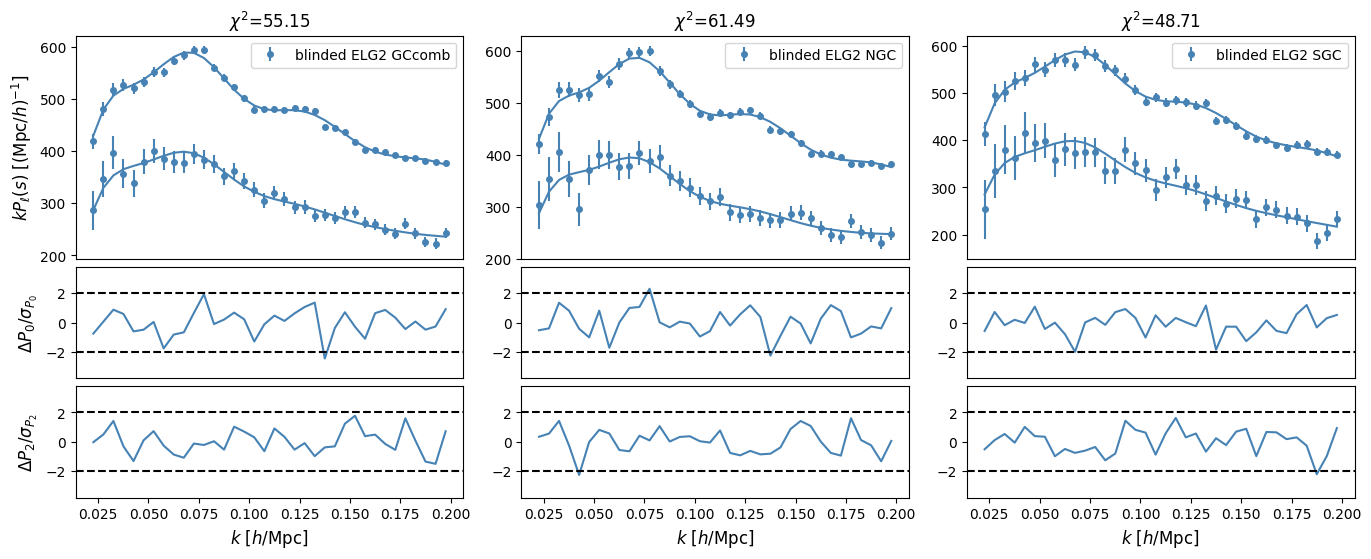

36
36
36
36
36
36


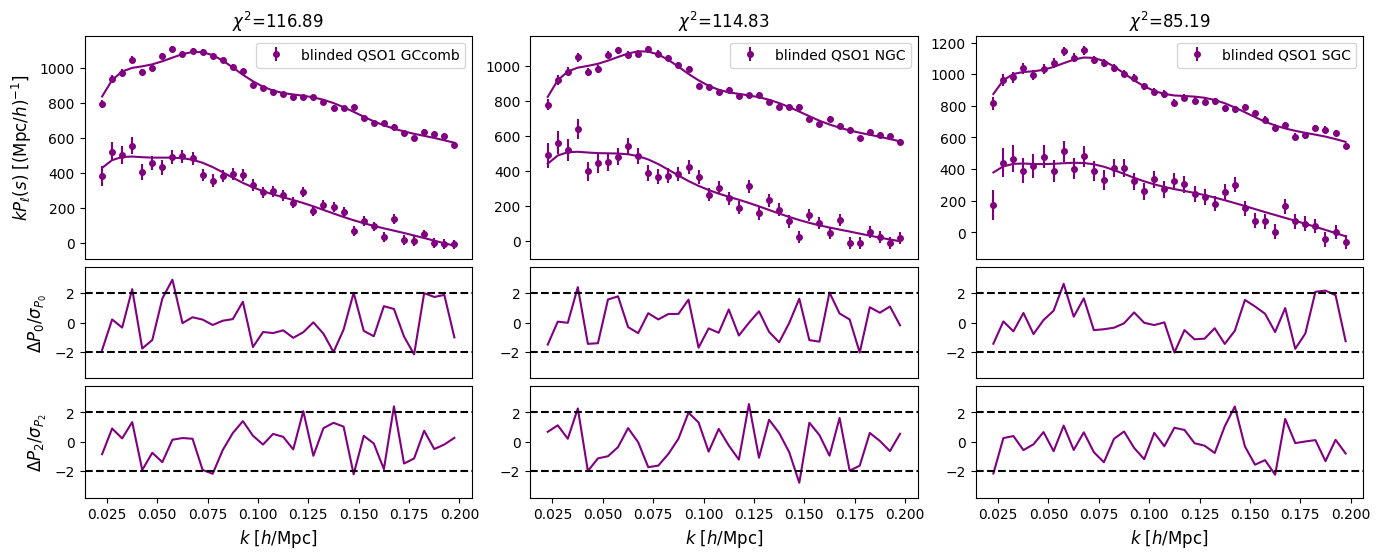

In [16]:
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_blinding')
for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    tracer_label = get_namespace(tracer, zrange)
    color = COLOR_TRACERS[tracer_label]

    regions = ['GCcomb','NGC','SGC']
    fig = plt.figure(figsize=(5.5 * len(regions), 6))
    gs = gridspec.GridSpec( 3, len(regions), wspace=0.15, hspace=0.05, height_ratios=[2, 1, 1])

    ax_top = []
    ax_bottom = [[], []]  # [row1, row2]
    for j in range(len(regions)):
        ax_top.append(plt.subplot(gs[0, j]))
        ax_bottom[0].append(plt.subplot(gs[1, j], sharex=ax_top[0]))
        ax_bottom[1].append(plt.subplot(gs[2, j], sharex=ax_top[0]))

    # for region in ['GCcomb','NGC','SGC']:
    for j,region in enumerate(regions):
        plot_kwargs = {'color':color, 'label':f'blinded {tracer_label} {region}'}
        data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
        emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}.npy'
        fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None, 'emulator_fn':emulator_fn}
        (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
        chain0 = all_chains[f'{tracer}_{zrange}_{region}']
        chain = chain0.remove_burnin(remove_burnin)
        likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
        plot_observable(observable, ax_top[j], [ax_bottom[0][j], ax_bottom[1][j]], **plot_kwargs)
        ax_top[j].set_title(r'$\chi^2$'+f'={-2*likelihood():.2f}')
    for j in range(1, len(regions)):
        for ax in [ax_top[j], ax_bottom[0][j], ax_bottom[1][j]]:
             ax.set_ylabel('')
    plt.show()
    if save_fig == True:
        fig.savefig(SAVE_DIR+f'/plots/clustering_with_{fit}bf_{tracer_label}_GCcompare.png', dpi=300, bbox_inches='tight')

## Posterior Plot

/tmp/ipykernel_532472/151807364.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


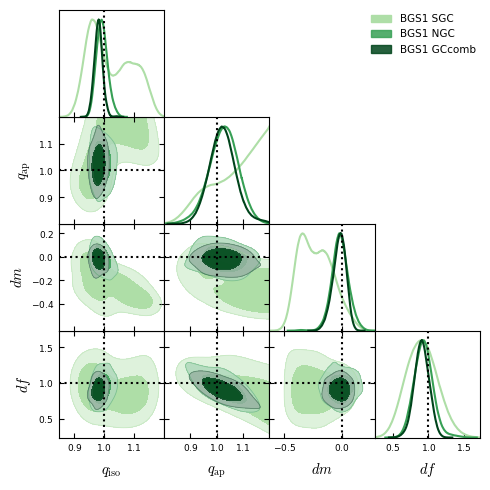

/tmp/ipykernel_532472/151807364.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


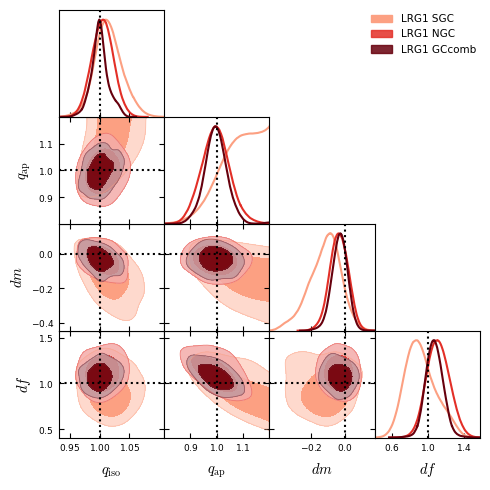

/tmp/ipykernel_532472/151807364.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


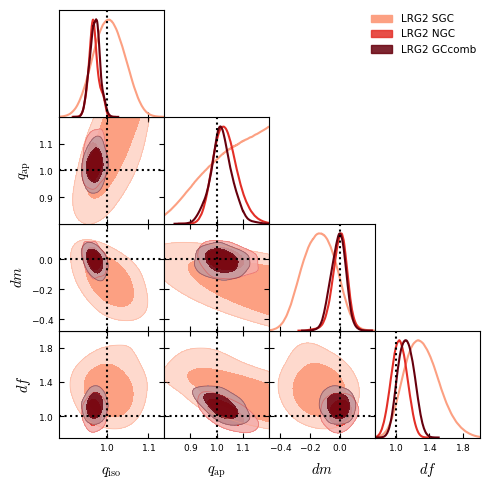

/tmp/ipykernel_532472/151807364.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


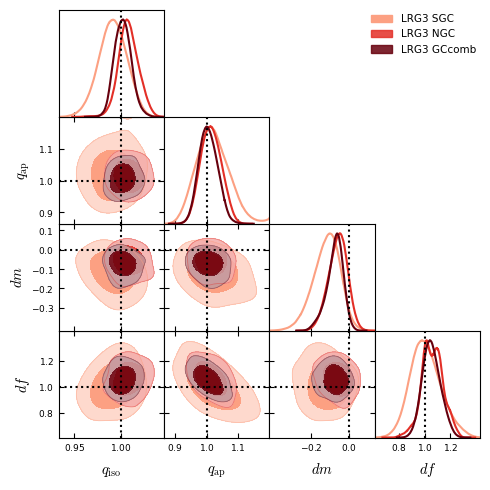

/tmp/ipykernel_532472/151807364.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


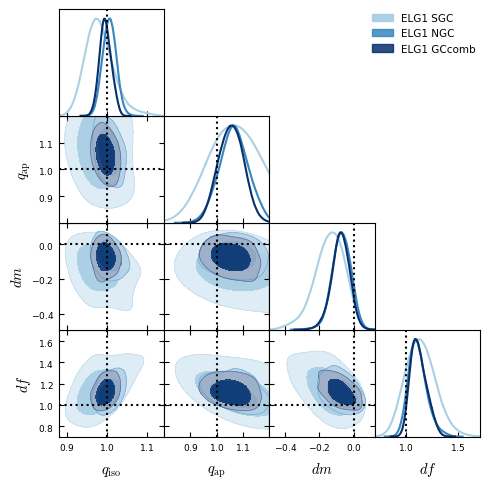

/tmp/ipykernel_532472/151807364.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


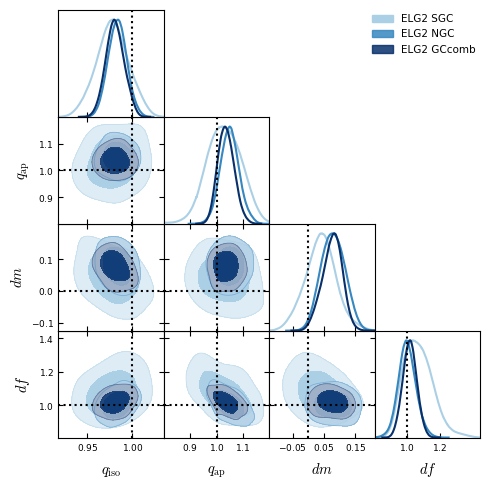

/tmp/ipykernel_532472/151807364.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('Purples')(np.linspace(0, 1, 4))[:]


Removed no burn in
Removed no burn in
Removed no burn in


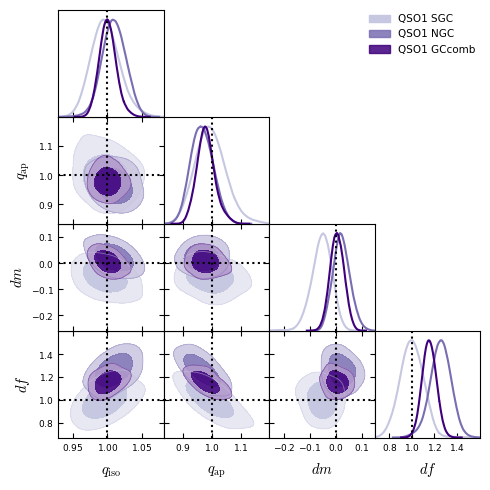

In [ ]:
# posterior corener plot
params = mcmc_args['params']

for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    chains = []
    colors = []
    labels = []
    # colormap = get_cmap('inferno')(np.linspace(0, 1, 6))
    map = 'vidirs'
    if tracer == 'BGS': 
        colormap = get_cmap('Greens')(np.linspace(0, 1, 4))[:]
    if tracer == 'LRG':
        colormap = get_cmap('Reds')(np.linspace(0, 1, 4))[:]
    if tracer == 'ELG': 
        colormap = get_cmap('Blues')(np.linspace(0, 1, 4))[:]
    if tracer == 'QSO': 
        colormap = get_cmap('Purples')(np.linspace(0, 1, 4))[:]
    for itask, region in enumerate(['SGC', 'NGC', 'GCcomb']):
        param_value = []
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        tracer_label = get_namespace(tracer, zrange)
        chain_fn = RESULT_DIR +f'/full-shape/mcmc/chain_{fit}fit_LCDM_vel_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}.npy'
        chain = Chain.load(chain_fn).remove_burnin(remove_burnin)[::slice_step]
        chains.append(chain)
        colors.append(tuple(colormap[itask+1]))
        labels.append(f'{tracer_label} {region}')
        # print(region, chain.to_stats(params = ['logA','b1p'], tablefmt='pretty'))
    g = plots.get_subplot_plotter()
    g.settings.fig_width_inch= 5
    g.settings.legend_fontsize = 12
    g.settings.axes_labelsize = 15
    g.settings.figure_legend_frame = False
    plotting.plot_triangle(chains, 
                            params = params,
                            legend_labels = labels, legend_loc= 'upper right',
                            contour_lws = 1.5, contour_colors = colors, contour_ls = ['-', '-', '-', '-'],
                            smoothed=True, show=False, filled = [True,True,True,True], g=g
                            )
    true_values = mcmc_args['true_values']
    for i, pi in enumerate(params):
        for j, pj in enumerate(params[:i+1]):
            ax = g.subplots[i, j]
            ax.axvline(true_values[pj], c='k', ls=':', lw=1.5)
            if i != j:
                ax.axhline(true_values[pi], c='k', ls=':', lw=1.5)
        g.fig.savefig(SAVE_DIR+f'/plots/corner_{fit}_{tracer_label}_GCcompare', dpi=300, bbox_inches='tight')
    plt.show()

In [45]:
import pandas as pd
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_blinding')

regions = ["GCcomb", "NGC", "SGC"]
rows = []

for param, param_label in zip(mcmc_args['params'], mcmc_args['params_label']):
    for tracer, zrange in TRACER_BINS:
        # match the naming you used for the chains
        raw_tracer = tracer
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        tracer_label = get_namespace(tracer, zrange)  # this will be your tracer_bin column name
        for region in regions:
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            mean = chain.mean(params=param)
            q05, q95 = chain.quantile(params=param)  # 5% and 95%
            data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
            emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}.npy'
            fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None, 'emulator_fn':emulator_fn}
            (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
            chi2 = -2*likelihood()
            # store raw numbers
            rows.append({"name": tracer_label, "region": region,
                        "param": param, "param_label": param_label,
                         "chi2": chi2, "mean": mean, "q05": q05, "q95": q95, })

df = pd.DataFrame(rows)

df
df.to_csv(f"../results/tables/table_{fit}fit_values.csv", index=False)